# Jeu de données avec des catégories

Le jeu de données [Adult Data Set](https://archive.ics.uci.edu/ml/datasets/adult) ne contient presque que des catégories. Ce notebook explore différentes moyens de les traiter.

In [1]:
%matplotlib inline

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## données

In [3]:
from papierstat.datasets import load_adult_dataset
train, test = load_adult_dataset(url="copy")
train.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,<=50K
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
label = '<=50K'
set(train[label])

{'<=50K', '>50K'}

In [5]:
set(test[label])

{'<=50K', '>50K'}

In [6]:
X_train = train.drop(label, axis=1)
y_train = train[label] == '>50K'
X_test = test.drop(label, axis=1)
y_test = test[label] == '>50K'

In [7]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
<=50K             object
dtype: object

La variable *fnlwgt* représente une forme de pondération : le nombre d'individus que chaque observation représente. Elle ne doit pas servir à la prédiction, comme pondération qu'on ignorera : cette pondération n'est pas liée aux données mais à l'échantillon et elle est impossible à construire. Il faut s'en passer.

In [8]:
X_train = X_train.drop(['fnlwgt'], axis=1).copy()
X_test = X_test.drop(['fnlwgt'], axis=1).copy()

## catégories

On garde la liste des variables catégorielles.

In [9]:
cat_col = list(_ for _ in X_train.select_dtypes("object").columns)
cat_col

['workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country']

La fonction [get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) est pratique mais problématique si les modalités de la base d'apprentissage et la base de test sont différentes, ce qui est fréquemment le cas pour les catégories peu fréquentes. Il faudrait regrouper les deux bases, l'appliquer puis sépareer à nouveau. Trop long. On veut utiliser [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) et [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) mais ce n'est pas très pratique parce que [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) n'accepte que les colonnes entières et [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) et peut traiter qu'une colonne à la fois.

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
pipe = make_pipeline(LabelEncoder(), OneHotEncoder())
try:
    pipe.fit(X_train[cat_col[0]], y_train)
except Exception as e:
    print(e)

fit_transform() takes 2 positional arguments but 3 were given


On utilise [OneHotEncoder](http://contrib.scikit-learn.org/categorical-encoding/) du module [category_encoders](http://contrib.scikit-learn.org/categorical-encoding/).

In [11]:
from category_encoders import OneHotEncoder
ce = OneHotEncoder(cols=cat_col, impute_missing=False, drop_invariant=False, handle_unknown='error')
X_train_cat = ce.fit_transform(X_train)
X_train_cat.head()

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,workclass_5,workclass_6,workclass_7,workclass_8,education_0,...,native_country_37,native_country_38,native_country_39,native_country_40,native_country_41,age,education_num,capital_gain,capital_loss,hours_per_week
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,39,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,50,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,38,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,53,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,28,13,0,0,40


C'est assez compliqué à lire. Le code suivant ne produit pas toujours un résultat correct si ``drop_invariant=False`` ou si ``handle_unknown!='error'`` car le nombre de colonnes change en fonction de ces options.

In [12]:
cols = []
for co in X_train.columns:
    if co in cat_col:
        ind = cat_col.index(co)
        mapping = ce.category_mapping[ind]['mapping']
        for m in mapping:
            cols.append(co + "/" + m[0].strip())
X_train_cat.columns = cols + list(X_train_cat.columns)[len(cols):]
X_train_cat.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Vietnam,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,39,13,2174,0,40
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,50,13,0,0,13
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,38,9,0,0,40
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,53,7,0,0,40
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,28,13,0,0,40


C'est plus clair.

## premier jet

On construit un [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [13]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(
            OneHotEncoder(cols=cat_col, impute_missing=False, drop_invariant=False, handle_unknown='error'), 
            LogisticRegression())
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('logisticregression', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [14]:
pipe.score(X_test, y_test)

0.8516061666973773

On essaye avec une [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [15]:
from sklearn.ensemble import RandomForestClassifier
pipe2 = make_pipeline(ce, RandomForestClassifier(n_estimators=100))
pipe2.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('randomforestclassifier', RandomFor...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [16]:
pipe2.score(X_test, y_test)

0.8447884036607088

In [17]:
pipe2.steps[-1][-1].feature_importances_[:5]

array([0.00514186, 0.00920545, 0.01121818, 0.00554595, 0.00619057])

On regarde l'[importance des features](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [18]:
import pandas
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe2.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
df.head()

,importance
name,
age,0.226922
hours_per_week,0.113115
capital_gain,0.107595
marital_status/Married-civ-spouse,0.072686
education_num,0.067473


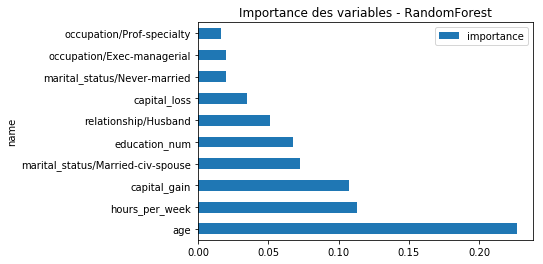

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - RandomForest');

On compare avec [XGBoost](http://xgboost.readthedocs.io/en/latest/model.html). L'âge semble la variable plus importante. Cela dit, si ce graphique donne quelque piste, ce n'est pas la vérité car les variables peuvent être corrélées. Deux variables corrélées sont interchangeables.

In [20]:
from xgboost import XGBClassifier
pipe3 = make_pipeline(ce, XGBClassifier())
pipe3.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('xgbclassifier', XGBClassifier(base...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [21]:
pipe3.score(X_test, y_test)

c:\Python364_x64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.869172655242307

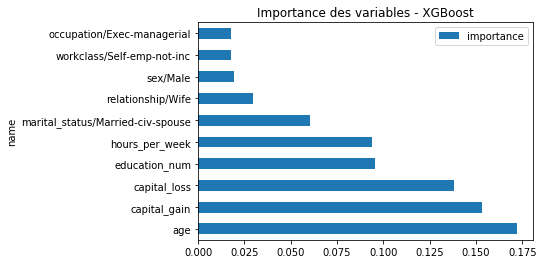

In [22]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe3.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - XGBoost');

On retrouve presque les mêmes variables mais pas dans le même ordre. On essaye un dernier module [catboost](https://tech.yandex.com/catboost/).

In [23]:
from catboost import CatBoostClassifier
pipe4 = make_pipeline(ce, CatBoostClassifier(iterations=100, verbose=False))
pipe4.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('catboostclassifier', <catboost.core.CatBoostClassifier object at 0x000001B302590C88>)])

In [24]:
pipe4.score(X_test, y_test)

0.8631533689576807

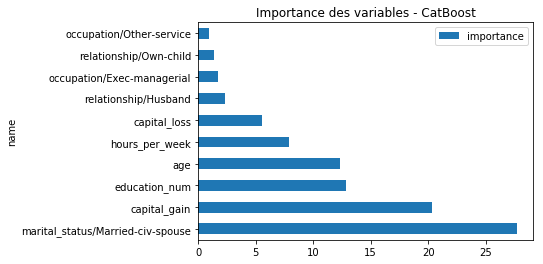

In [25]:
df = pandas.DataFrame(dict(name=X_train_cat.columns, 
                           importance=pipe4.steps[-1][-1].feature_importances_))
df = df.sort_values("importance", ascending=False).reset_index(drop=True)
df = df.set_index('name')
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
df[:10].plot.barh(ax=ax)
ax.set_title('Importance des variables - CatBoost');

Les modèles sont à peu près d'accord sur la performance mais pas vraiment sur l'ordre des features les plus importantes. Comme ce sont tous des random forests, même apprises différemment, on peut supposer qu'il existe des corrélations entre les variables. Des corrélations au sens du modèle donc pas nécessairement linéaires.

## Courbe ROC

In [26]:
from sklearn.metrics import roc_curve
fpr2, tpr2, th2 = roc_curve(y_test, pipe2.predict_proba(X_test)[:, 1], 
                            pos_label=pipe2.steps[-1][-1].classes_[1], drop_intermediate=False)
fpr3, tpr3, th3 = roc_curve(y_test, pipe3.predict_proba(X_test)[:, 1], 
                            pos_label=pipe3.steps[-1][-1].classes_[1], drop_intermediate=False)
fpr4, tpr4, th4 = roc_curve(y_test, pipe4.predict_proba(X_test)[:, 1], 
                            pos_label=pipe4.steps[-1][-1].classes_[1], drop_intermediate=False)

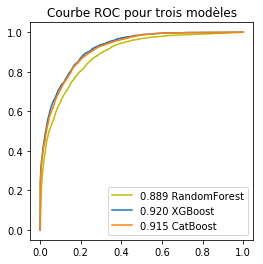

In [27]:
from sklearn.metrics import auc
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(fpr2, tpr2, label='%1.3f RandomForest' % auc(fpr2, tpr2), color='y')
ax.plot(fpr3, tpr3, label='%1.3f XGBoost' % auc(fpr3, tpr3))
ax.plot(fpr4, tpr4, label='%1.3f CatBoost' % auc(fpr4, tpr4))
ax.legend()
ax.set_title('Courbe ROC pour trois modèles');

## GridSearch

On cherche à optimiser les hyperparamètres sur la base d'apprentissage. On vérifie d'abord que les données sont bien identiquement distribuées. La validation croisée considère des parties contigües de la base de données. Il arrive que les données ne soient pas tout-à-fait homogènes et qu'il faille les mélanger. On compare les performances avant et après mélange pour vérifier que l'ordre des données n'a pas d'incidence.

In [28]:
from sklearn.model_selection import cross_val_score
cross_val_score(pipe2, X_train, y_train, cv=5)

array([0.84784278, 0.84136978, 0.84336609, 0.8519656 , 0.84935504])

In [29]:
from pandas_streaming.df import dataframe_shuffle
from numpy.random import permutation
index = permutation(X_train.index)
X_train_shuffled = X_train.iloc[index, :]
y_train_shuffled = y_train[index]
cross_val_score(pipe2, X_train_shuffled, y_train_shuffled, cv=5)

array([0.84154767, 0.84520885, 0.84689803, 0.84597666, 0.85426904])

L'ordre de la base n'a pas d'incidence.

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = {'randomforestclassifier__n_estimators':[10, 20, 50],
              'randomforestclassifier__min_samples_leaf': [2, 10]}
cvgrid = GridSearchCV(estimator=pipe2, param_grid=param_grid, verbose=2)
cvgrid.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   3.7s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   3.9s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=10, total=   3.7s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   4.0s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   4.0s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20 
[CV]  randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=20, total=   4.5s
[CV] randomforestclassifier__min_samples_leaf=2, randomforestclassifier__n_estimators=50 
[CV]  randomforestclassif

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('randomforestclassifier', RandomFor...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'randomforestclassifier__n_estimators': [10, 20, 50], 'randomforestclassifier__min_samples_leaf': [2, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [31]:
import pandas
df = pandas.DataFrame(cvgrid.cv_results_['params'])
df['mean_fit_time'] = cvgrid.cv_results_['mean_fit_time']
df['mean_test_score'] = cvgrid.cv_results_['mean_test_score']
df.sort_values('mean_test_score')

,randomforestclassifier__min_samples_leaf,randomforestclassifier__n_estimators,mean_fit_time,mean_test_score
3,10,10,2.605636,0.855318
4,10,20,3.344591,0.858420
5,10,50,4.481414,0.859771
0,2,10,2.837100,0.860723
1,2,20,3.114079,0.861675
2,2,50,4.669397,0.864961


Il faudrait continuer à explorer les hyperparamètres et confirmer sur la base de test. A priori, cela marche mieux avec plus d'arbres.

## Features polynômiales

On essaye même si cela a peu de chance d'aboutir compte tenu des variables, principalement catégorielles, et du fait qu'on utilise une forêt aléatoire.

In [32]:
from sklearn.preprocessing import PolynomialFeatures
pipe5 = make_pipeline(ce, PolynomialFeatures(), RandomForestClassifier())
pipe5.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country'],
       drop_invariant=False, handle_unknown='error', impute_missing=False,
       return_df=True, verbose=0)), ('polynomialfeatures', PolynomialFea...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [33]:
pipe5.score(X_test, y_test)

0.8415944966525398

Ca n'améliore pas.

## Interprétation

On souhaite en savoir plus sur les variables.

In [34]:
conc = pandas.concat([X_train_cat, y_train], axis=1)
conc.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week,<=50K
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,39,13,2174,0,40,False
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,50,13,0,0,13,False
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,38,9,0,0,40,False
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,53,7,0,0,40,False
4,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,28,13,0,0,40,False


In [35]:
corr = conc.corr()

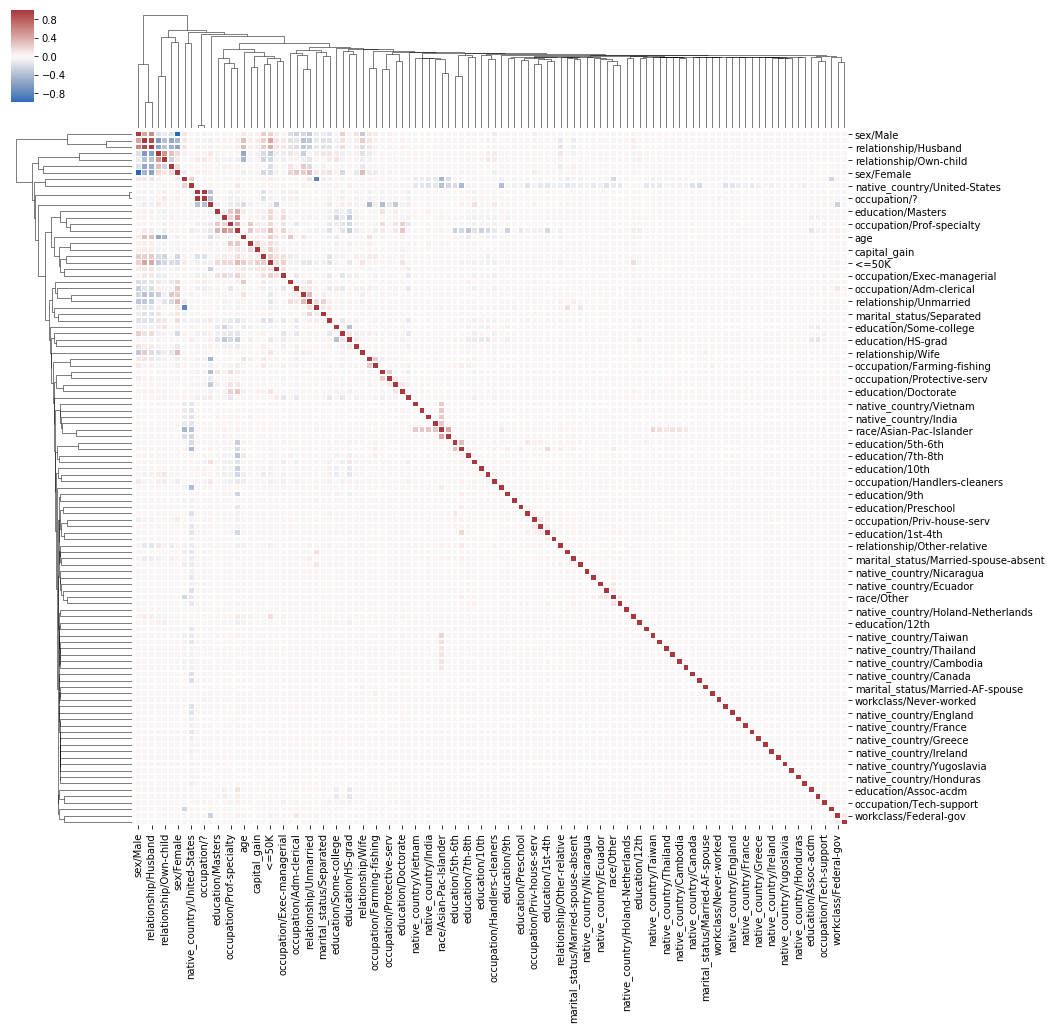

In [36]:
from seaborn import clustermap

clustermap(corr, center=0, cmap="vlag", linewidths=.75, figsize=(15, 15));

Ce n'est pas facile à voir. Il faudrait essayer avec [bokeh](https://bokeh.pydata.org/en/latest/docs/gallery/les_mis.html) ou essayer de procéder autrement.

## ACM

Ce qui suit n'est pas tout-à-fait une [ACM](https://fr.wikipedia.org/wiki/Analyse_des_correspondances_multiples) mais cela s'en inspire. On considère les variables comme des observations et on les projette sur des plans définis par les axes d'une [ACP](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales). On normalise également car on mélange variables continues et variables binaires d'ordre de grandeur différents. Les calculs sont plus précis lorsque les matrices ont des coefficients de même ordre. Le dernier exercice de cet examen [Programmation ENSAE 2006](http://www.xavierdupre.fr/site2013/enseignements/tdnote/ecrit_2006.pdf) achèvera de vous convaincre.

In [37]:
from sklearn.preprocessing import StandardScaler
import pandas
rows_cat = pandas.DataFrame(StandardScaler().fit_transform(X_train_cat))
rows_cat.columns = X_train_cat.columns
rows_cat = rows_cat.T
rows_cat.head(n=2)

,0,1,2,3,4,5,6,7,8,9,...,32551,32552,32553,32554,32555,32556,32557,32558,32559,32560
workclass/State-gov,4.907700,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,...,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761,-0.203761
workclass/Self-emp-not-inc,-0.290936,3.437186,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,3.437186,-0.290936,-0.290936,...,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936,-0.290936


In [38]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(rows_cat)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [39]:
import pandas
tr = pandas.DataFrame(pca.transform(rows_cat))
tr.columns = ['axe1', 'axe2', 'axe3']
tr.index = rows_cat.index
tr.sort_values('axe1').head(n=2)

,axe1,axe2,axe3
sex/Female,-129.496963,60.787399,28.384800
marital_status/Never-married,-106.132540,-11.462856,-53.652512


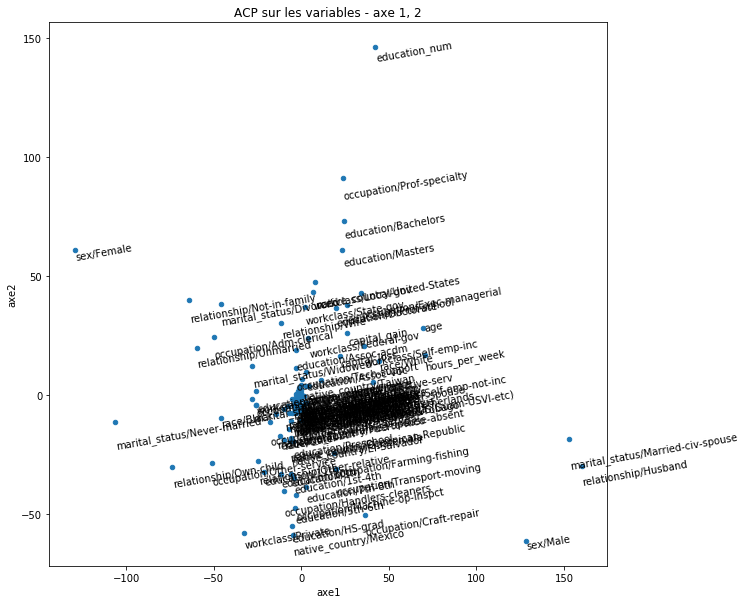

In [40]:
ax = tr.plot(x='axe1', y='axe2', kind='scatter', figsize=(10, 10))
for t, (x, y, z) in tr.iterrows():
    ax.text(x, y, t, fontsize=10, rotation=10)
ax.set_title("ACP sur les variables - axe 1, 2");

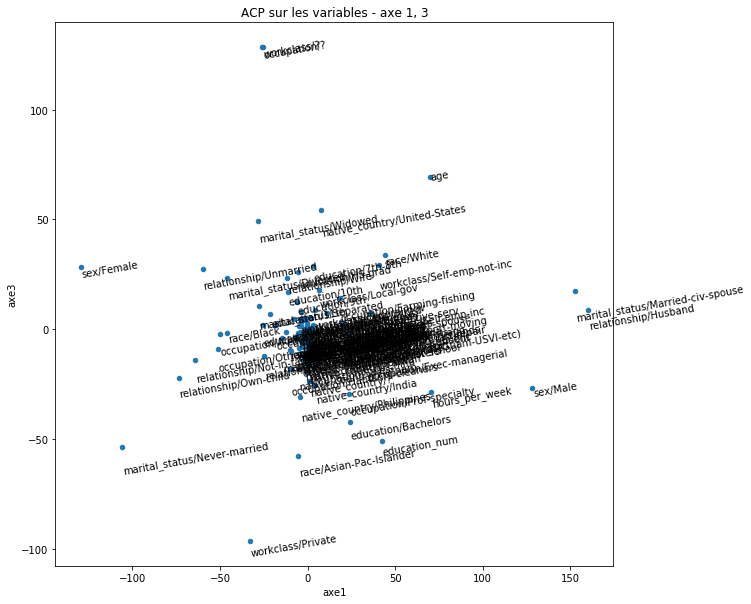

In [41]:
ax = tr.plot(x='axe1', y='axe3', kind='scatter', figsize=(10, 10))
for t, (x, y, z) in tr.iterrows():
    ax.text(x, z, t, fontsize=10, rotation=10)
ax.set_title("ACP sur les variables - axe 1, 3");

On voit quelques variables à supprimer car très corrélées comme la relation ou la situation maritale. On voit aussi que les deux genres homme/femme sont opposés. On voit aussi que certaines catégories sont très proches comme Prof, Masters ou diplômés. Il est probable que le modèle de prédiction ne pâtisse pas du regroupement de ces trois catégories. On utilise [bokeh](https://bokeh.pydata.org/en/latest/) pour pouvoir zoomer.

In [42]:
import bokeh, bokeh.io as bio
bio.output_notebook()

Loading BokehJS ...

In [43]:
from bokeh.plotting import figure, show
p = figure(title="ACP sur les variables - axe 1, 2")
p.circle(tr["axe1"], tr["axe2"])
p.text(tr["axe1"], tr["axe2"], tr.index,
       text_font_size="8pt", text_baseline="middle", angle=0.1)
show(p)

## Analyse d'erreur

On recherche les erreurs les plus flagrantes, celles dont le score est élevé.

In [44]:
pred = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)
pred2 = pipe2.predict(X_test)
proba2 = pipe2.predict_proba(X_test)
pred3 = pipe3.predict(X_test)
proba3 = pipe3.predict_proba(X_test)
pred4 = pipe4.predict(X_test)
proba4 = pipe4.predict_proba(X_test)

c:\Python364_x64\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [45]:
data = pandas.concat([
            pandas.DataFrame(y_test.astype(float).as_matrix(), columns=['y_test']),
            pandas.DataFrame(pred, columns=['pred1']),
            pandas.DataFrame(proba[:,1], columns=['P1(>=50K)']),
            pandas.DataFrame(pred2, columns=['pred2']),
            pandas.DataFrame(proba2[:,1], columns=['P2(>=50K)']),
            pandas.DataFrame(pred3, columns=['pred3']),
            pandas.DataFrame(proba3[:,1], columns=['P3(>=50K)']),
            pandas.DataFrame(pred4, columns=['pred4']),
            pandas.DataFrame(proba4[:,1], columns=['P4(>=50K)']),
            X_test,
            ], axis=1)
data.head()

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
0,0.0,False,0.002997,False,0.000000,False,0.007642,0.0,0.009549,25,...,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,0.0,False,0.138880,False,0.056000,False,0.203497,0.0,0.293875,38,...,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,1.0,False,0.364649,False,0.489167,False,0.277167,0.0,0.311410,28,...,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,1.0,True,0.754975,True,0.900000,True,0.984138,1.0,0.953226,44,...,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,0.0,False,0.001904,False,0.000000,False,0.002210,0.0,0.005256,18,...,10,Never-married,?,Own-child,White,Female,0,0,30,United-States


In [46]:
data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=False).head().T

,3605,4143,2926,786,1418
y_test,0,0,0,0,0
pred1,True,True,True,True,True
P1(>=50K),0.999997,0.927754,0.779498,0.844606,0.97892
pred2,True,True,True,True,True
P2(>=50K),0.82,0.87,0.75,0.81,0.93
pred3,True,True,True,True,True
P3(>=50K),0.972606,0.881992,0.900088,0.838751,0.833428
pred4,1,1,1,1,1
P4(>=50K),0.969863,0.939031,0.919761,0.913337,0.90276
age,36,64,65,67,55


Tous les modèles font l'erreur sur ces cinq exemples. Le modèle a toutes les raisons de décider que les personnes gagnent plus de 50k par an, beaucoup d'études, plutôt âge ou travaillant beaucoup.

In [47]:
wrong_study = data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head(n=3).T
wrong_study

,10408,5953,3059
y_test,1,1,1
pred1,False,False,False
P1(>=50K),0.00219724,0.00231258,0.0280105
pred2,False,False,False
P2(>=50K),0,0,0
pred3,False,False,False
P3(>=50K),0.00288558,0.00299048,0.00561586
pred4,0,0,0
P4(>=50K),0.00567877,0.00718187,0.00838786
age,22,20,22


Ceux-ci sont probablement étudiants et déjà aisés. Il faudrait avoir quelques informations sur les parents pour confirmer. On recherche les plus proches voisins dans la base pour voir ce que le modèle répond. Il faut néanmoins appliquer cela sur la base une fois les catégories transformées.

In [48]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors()
knn.fit(X_train_cat)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [49]:
X_test_cat = pipe2.steps[0][-1].transform(X_test)
X_test_cat.columns = X_train_cat.columns

In [50]:
wrong = data[data.y_test != data.pred4].sort_values('P4(>=50K)', ascending=True).head()
wrong.head(n=2)

,y_test,pred1,P1(>=50K),pred2,P2(>=50K),pred3,P3(>=50K),pred4,P4(>=50K),age,...,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country
10408,1.0,False,0.002197,False,0.0,False,0.002886,0.0,0.005679,22,...,10,Never-married,?,Own-child,White,Male,0,0,15,?
5953,1.0,False,0.002313,False,0.0,False,0.002990,0.0,0.007182,20,...,8,Never-married,Other-service,Own-child,Black,Male,0,0,35,United-States


In [51]:
wrong_cat = X_test_cat.iloc[wrong.index, :]
wrong_cat.head()

,workclass/State-gov,workclass/Self-emp-not-inc,workclass/Private,workclass/Federal-gov,workclass/Local-gov,workclass/?,workclass/Self-emp-inc,workclass/Without-pay,workclass/Never-worked,education/Bachelors,...,native_country/Vietnam,native_country/Hong,native_country/Ireland,native_country/Hungary,native_country/Holand-Netherlands,age,education_num,capital_gain,capital_loss,hours_per_week
10408,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,22,10,0,0,15
5953,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,20,8,0,0,35
3059,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,22,10,0,0,25
11821,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,24,7,0,0,40
7720,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,23,10,0,0,40


In [52]:
dist, index = knn.kneighbors(wrong_cat)
dist

array([[2.        , 2.        , 2.23606798, 2.44948974, 2.44948974],
       [1.41421356, 1.41421356, 2.23606798, 2.23606798, 2.23606798],
       [1.        , 1.41421356, 1.41421356, 1.73205081, 1.73205081],
       [1.41421356, 1.73205081, 1.73205081, 1.73205081, 2.        ],
       [2.        , 2.        , 2.23606798, 2.23606798, 2.23606798]])

In [53]:
index

array([[18056, 18362,  8757, 13177,   314],
       [24878, 30060, 27902,  8008, 23771],
       [  920, 31176,  5206,  7415, 15308],
       [17303, 18592,  2019, 20325,  7542],
       [26376, 12434,  3856,  7152, 12997]], dtype=int64)

In [54]:
train_nn = pandas.concat([X_train, y_train], axis=1).iloc[[24878, 18056, 920], :].T
train_nn.columns = ['TR-' + str(_) for _ in train_nn.columns]
train_nn

,TR-24878,TR-18056,TR-920
age,20,21,23
workclass,Private,?,Private
education,12th,Some-college,Some-college
education_num,8,10,10
marital_status,Never-married,Never-married,Never-married
occupation,Other-service,?,Sales
relationship,Own-child,Own-child,Not-in-family
race,White,White,White
sex,Male,Male,Male
capital_gain,0,0,0


Il faut comparer la première colonne avec la quatrième, la seconde avec la ciinquième et la troisème avec la sixième. Ces exemples sont voisins. On voit que les exemples sont très proches. Il n'y a qu'une seule valeur qui change à chaque fois et il est difficile d'expliquer les erreurs.

In [55]:
pandas.concat([train_nn, wrong_study], axis=1)

,TR-24878,TR-18056,TR-920,10408,5953,3059
<=50K,False,False,False,NaN,NaN,NaN
P1(>=50K),NaN,NaN,NaN,0.00219724,0.00231258,0.0280105
P2(>=50K),NaN,NaN,NaN,0,0,0
P3(>=50K),NaN,NaN,NaN,0.00288558,0.00299048,0.00561586
P4(>=50K),NaN,NaN,NaN,0.00567877,0.00718187,0.00838786
age,20,21,23,22,20,22
capital_gain,0,0,0,0,0,0
capital_loss,0,0,0,0,0,0
education,12th,Some-college,Some-college,Some-college,12th,Some-college
education_num,8,10,10,10,8,10


## Ethique

Le modèle qu'on a appris est-il éthique ?

## Sélection des variables